In [41]:
bitrates = [320, 256, 224, 192, 160, 128, 112, 96, 80, 64]
compressions = [
    {"name": "zip", "command": ["zip","-{level}","{output}","{input}"], "output": "file{level}.zip"},    
    {"name": "7z",  "command": ["7z","a","{output}","{input}","-mx={level}"], "output": "file.7z"},
    {"name": "flac","command": ["ffmpeg","-i","{input}","-c:a","flac",      "-compression_level","{level}","{output}"], "output": "file{level}.flac"},
    
    {"name": "vorbis","command": ["ffmpeg","-i","{input}","-c:a","libvorbis", "-b:a","{bitrate}k","{output}"], "output": "filevorbis{bitrate}.ogg"},
    {"name": "opus",  "command": ["ffmpeg","-i","{input}","-c:a","libopus",   "-b:a","{bitrate}k","{output}"], "output": "fileopus{bitrate}.ogg"},
    {"name": "mp3",   "command": ["ffmpeg","-i","{input}","-c:a","libmp3lame","-b:a","{bitrate}k","{output}"], "output": "file{bitrate}.mp3"},
    {"name": "aac",   "command": ["ffmpeg","-i","{input}","-c:a","aac",       "-b:a","{bitrate}k","{output}"], "output": "file{bitrate}.m4a"},    
]

In [42]:
import os
import subprocess
import datetime

def compress(input, compression, level):
    bitrate = bitrates[level]
    output = compression['output'].format(level=level, bitrate=bitrate)
    command = compression['command'].copy()
    for i in range(len(command)):
        command[i] = command[i].format(input=input, output=output, bitrate=bitrate, level=level)
    
    with open("log.txt","a") as f:
        f.write(' '.join(command));
        f.write('\n')
    
        start = datetime.datetime.now()
        subprocess.run(command, stdout=f, stderr=f)    
        end = datetime.datetime.now()
    
    time = (end-start).total_seconds() * 1000    
    file_size = os.path.getsize(output)
    
    os.remove(output)
    
    return {"name": compression['name'], "level":level, "time": time, "size": file_size}

In [43]:
import sys
from tqdm import tqdm

try:
    os.remove("log.txt")
except:
    pass

input = "audio/raw.wav"
initial_size = os.path.getsize(input)

results = []
with tqdm(total=len(compressions)*len(bitrates)) as pbar:
    for c in compressions:
        for level in range(len(bitrates)):
            result = compress(input, c, level)
            result['ratio'] = result['size']*100/initial_size
            results += [result]           
            pbar.update(1)

100%|██████████| 70/70 [05:00<00:00,  4.29s/it]


In [44]:
import pandas

df = pandas.DataFrame.from_dict(results)
df

,name,level,time,size,ratio
0,zip,0,224.332,42918142,100.000410
1,zip,1,1612.383,35887952,83.619881
2,zip,2,1570.823,35870296,83.578742
3,zip,3,1652.779,35823900,83.470638
4,zip,4,1846.879,35582248,82.907582
...,...,...,...,...,...
65,aac,5,3682.178,3897611,9.081537
66,aac,6,4549.364,3413611,7.953804
67,aac,7,3771.096,2933447,6.835009
68,aac,8,3767.857,2456380,5.723431


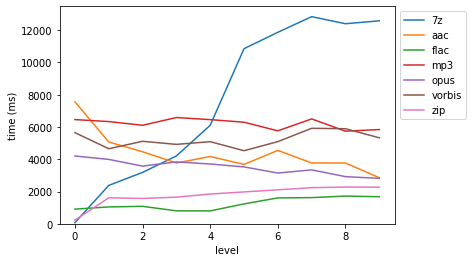

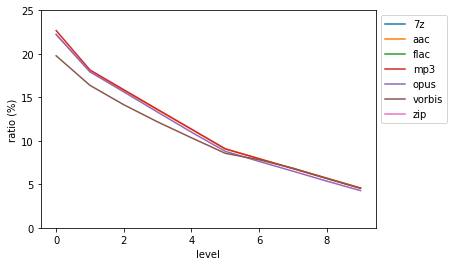

In [51]:
import matplotlib.pyplot as plt

df.pivot(index='level', columns='name', values='time').plot()
plt.ylabel('time (ms)')
plt.ylim(ymin=0)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

df.pivot(index='level', columns='name', values='ratio').plot()
plt.ylabel('ratio (%)')
plt.ylim(ymin=0, ymax=25)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()